In [1]:
import numpy as np
from mbdst import * # MBDST_true, MBDST_LP, MBDST1, MBDST2, 
                    # MBDST3 and one-step version of those
from utils import *
from timeit import Timer

from visualization import visualize_graph, fix_pos, make_graph

# for verbosity control
_log = print
def set_log(fun):
    global _log
    _log = fun

In [8]:
# test a single case
def test_single_MBDST(fun,N):
    case = gen_case(N, mode="fully") # fully connected case
    ret = fun(*case)
    return ret
test_single_MBDST(MBDST2,5)

array([0, 0, 1, 1, 0, 1, 0, 1, 0, 0])

In [30]:
# campare multiple cases to search for weird cases.
# when finding a weird case, append manually (the case is 
# format-ready in the output) to either list in weird_cases.py
# (bad manner but works for me)
def compare_results(funs,case=gen_case(5),report_degrees=False,report_costs=False):
    g,c,b = case
    ret = [f(g.copy(), c.copy(), b.copy()) for f in funs]
    for _ in (x for x in ret if x is None): 
    # some alg did not work
        return -1,{
            'names':[f.__name__ for f in funs],
            'x':ret,
            'case':(g,c,b)}
    if np.logical_or.reduce(np.stack(ret) != ret[0],axis=0).any(): 
    # some algs did not match
        return 1,{
                'names':[f.__name__ for f in funs],
                'x':ret,
                'case':(g,c,b)}
    # everything good
    return 0,{
                'names':[f.__name__ for f in funs],
                'x':ret,
                'case':(g,c,b)}

def report(stat,dic):
    g,c,b = dic['case']
    x = np.stack([x if x is not None else np.full_like(c,fill_value=0) for x in dic['x'] ])
    if stat == 0: # good
        return
    if stat == 1: # mismatch
        _log('got diff')
    if stat == -1: 
        if is_feasible(*dic['case']): # failed on feasible problem
            _log('got None BUT FEASIBLE')
        else: # failed as desired
            _log('got None as expected')
            _log('bounds:',b)
            return
    _log('x:')
    _log(x)
    _log('costs:')
    _log(c@x.T)
    _log('d bounds:')
    _log(b.astype(float))
    _log('degres:')
    _log(x@g.T)
    _log(dic['case'])
    return
for i in range(100):
    report(*compare_results((MBDST_LP,MBDST_true,MBDST1,MBDST2,MBDST3),
                            gen_case(6)))


got None as expected
bounds: [1 1 1 1 1 4]


In [36]:
# test running time
case = gen_case(8,mode='fully') # fully connected case
def test():
    MBDST2(*case)
t = Timer("test()", "from __main__ import test")
print(t.timeit(100))

8.239161912999407


In [28]:
# check single weird case
# to retrieve a case saved in weird_cases.py, use mode="weird" or "bug", 
# and N=the number where the case is inthe list.
report(*compare_results((MBDST_LP,MBDST_true,MBDST1,MBDST2,MBDST3),
                        gen_case(mode='bug',N=0)))


got diff
x:
[[0.  0.  0.  0.  0.  0.  0.  0.  1.  0.5 0.  0.  0.  1.  0.  0.5 0.  0.
  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0.5 0.  0.5 0.5 0.5 1.  0.  1.  0.
  0.  1.  0.  0.  0.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  0.  0. ]]
costs:
[-60.5 -60.  -63.  -40.  -63. ]
d bounds:
[1. 2. 1. 4. 

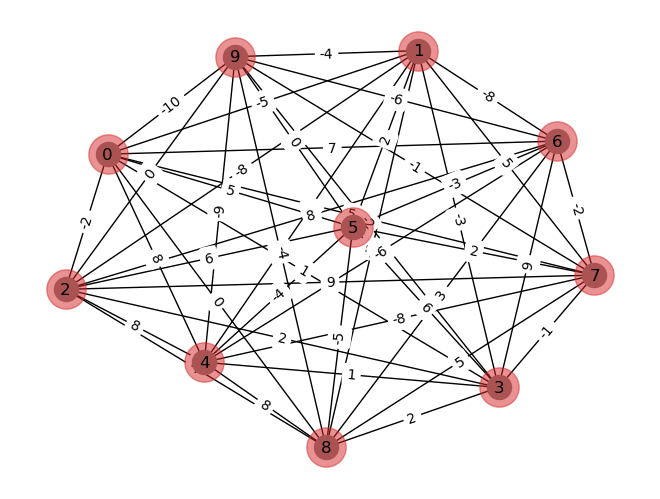

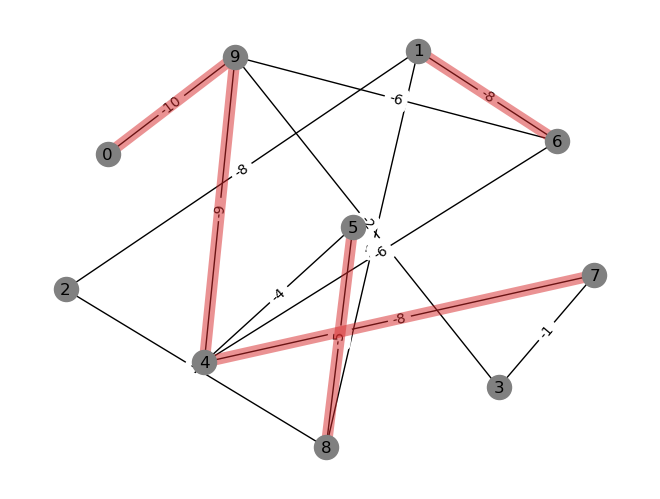

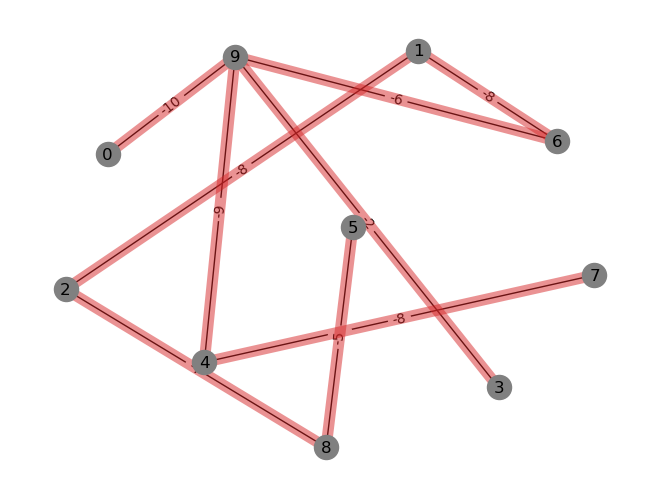

In [31]:
# visualize steps of the algorithm
def visualize_step(alg_step):
    def wait_for_space():
        key = ''
        while key != ' ':
            key = input("Press the spacebar to continue: ")
    def fun(G,C,B,pos=None):
        nv,ne=G.shape
        graph = make_graph(G.copy(),C)
        ret,step=alg_step(G,C,B)
        if pos is None:pos = fix_pos(graph)
        visualize_graph(graph,pos,None,ret,np.ones(nv))
        for gev in step():
            if gev is None: return None
            g,e,v = gev
            wait_for_space()
            # graph = make_graph(g,C)
            visualize_graph(graph,pos,g,ret.astype(bool),v)
    return fun

visualize_step(MBDST3_step)(*gen_case(mode='bug',N=0))

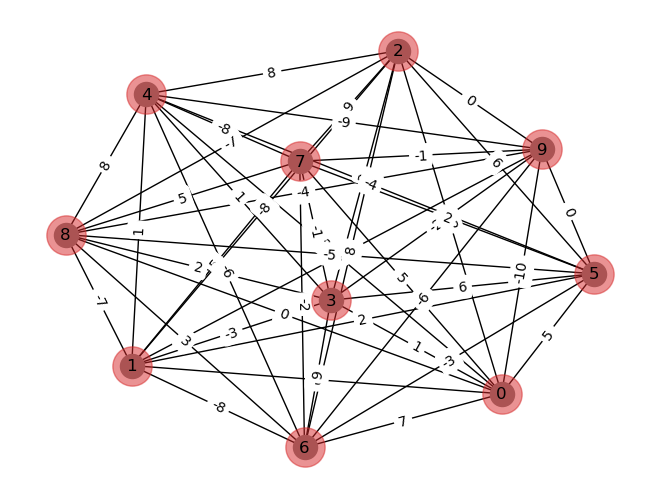

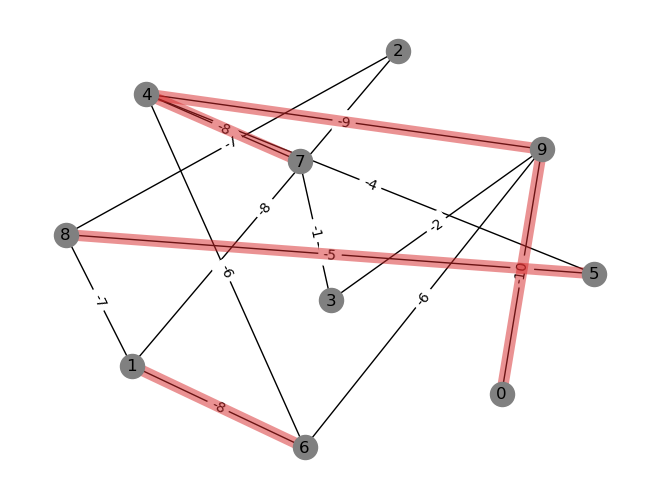

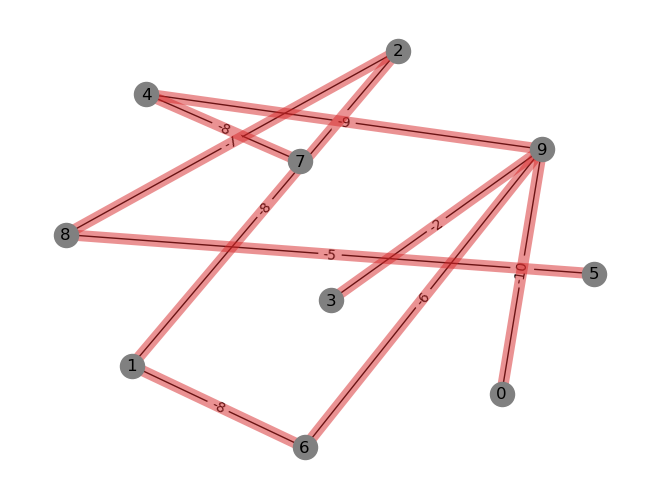

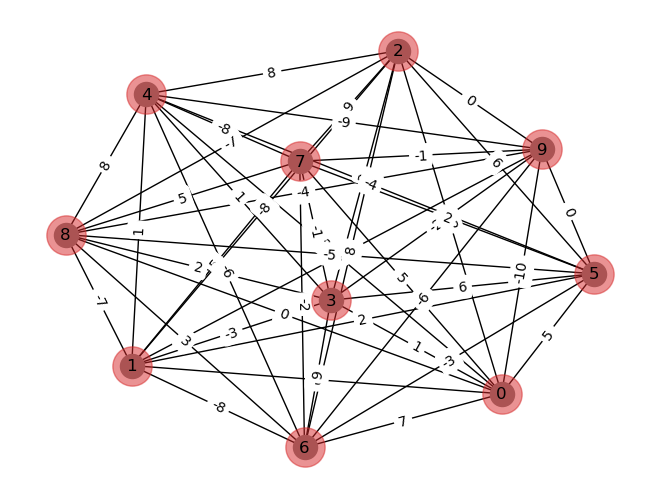

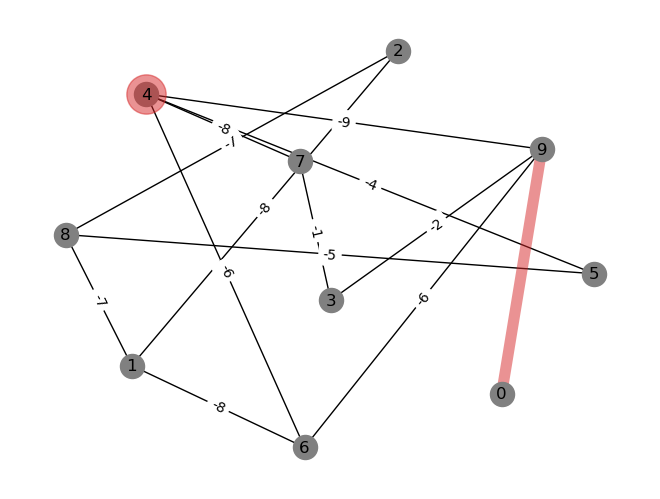

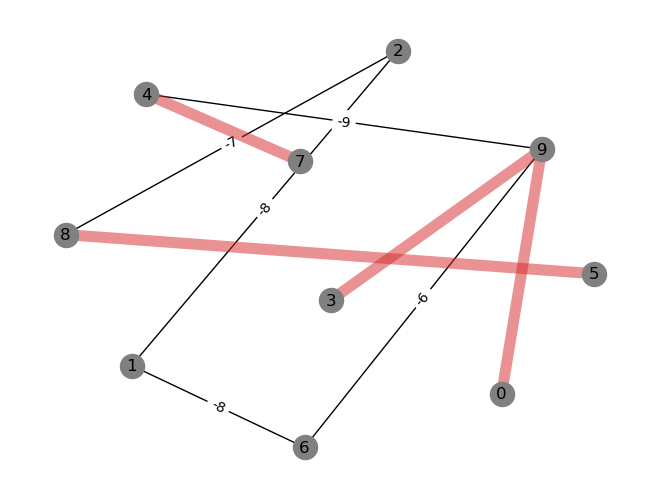

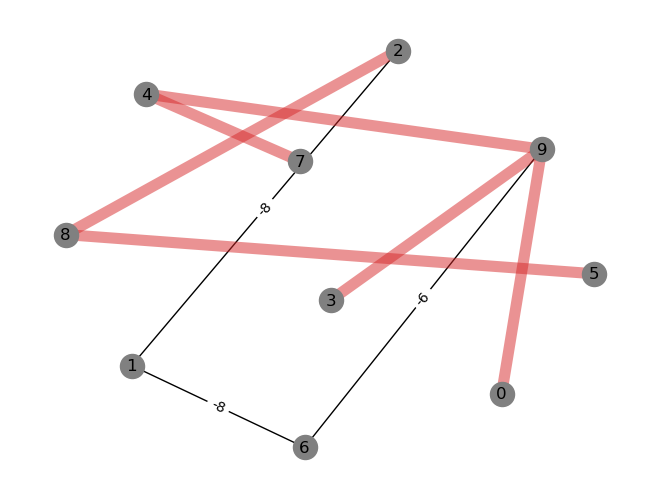

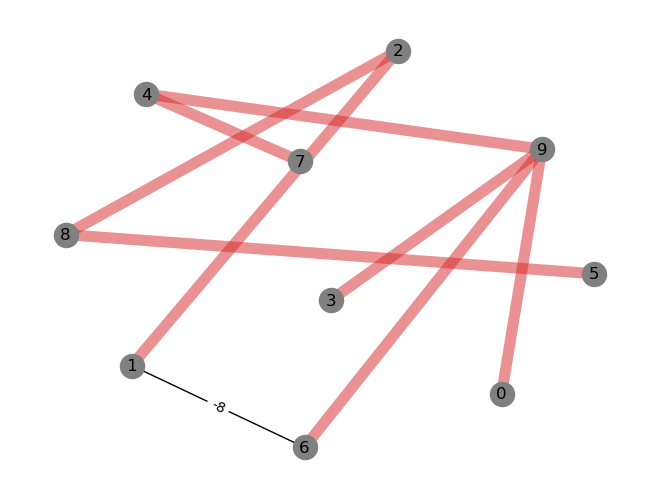

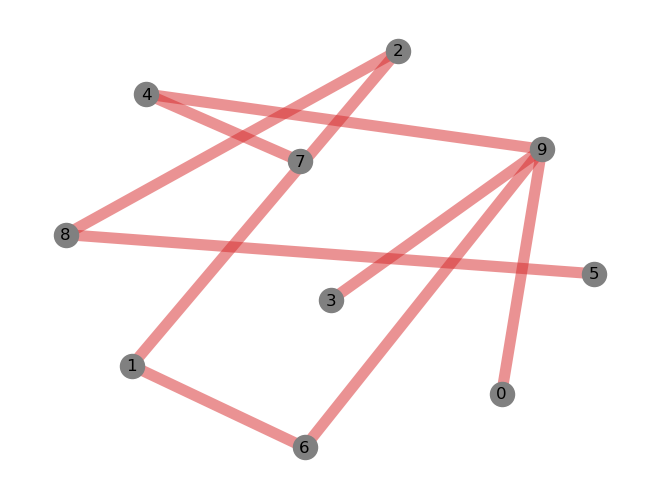

In [32]:
# fix node positions to do visualization on the same graph
# (bad code design)
G,C,B = gen_case(mode='bug',N=0)
pos = fix_pos(make_graph(G,C))
visualize_step(MBDST3_step)(*gen_case(mode='bug',N=0),pos)
visualize_step(MBDST1_step)(*gen_case(mode='bug',N=0),pos)

In [34]:
# ;)